# A Notebook showing 'reverse Deconvolution' a.k.a. PSF Distilling

This notebook has been developed in part to answer the below imagesc questions...

https://forum.image.sc/t/apply-astigmatism-to-a-model-psf/9768

https://forum.image.sc/t/pyme-psfextraction-creates-psfs-with-higher-than-expected-intensity-in-outer-rings/62973


In this notebook we perform a reverse deconvolution to solve for the PSF.  The acquired image is the convolution of a PSF and a 'true object'.  The 'true object' is the deconvolution of the image using the PSF.  However if we know the true object (in this case a field of sub-resolution beads) we can reverse the role of object and PSF, and solve for the PSF
```
Image=convolution(object,psf)

object=deconvolution(image,psf)

psf=deconvolution(image,object)
```

The notebook shows how to create a 'true object' from a field of sub-resolution beads using the prior knowledge of the shape of the beads (a sub-resolution point).  Then use the 'true object' to find an aproximation of the PSF using a reverse deconvolution

## Imports

In [1]:
from skimage.io import imread
from tnia.plotting.projections import show_xyz_max
from skimage.filters import threshold_otsu, threshold_local
from skimage.measure import label

## define image set and some parameters

In [45]:
tnia_dir = r"D:\images\tnia-python-images\\"
beads_name = r"deconvolution\beads\beads in agarose stack crop.tif"
axial_stretch=1

beads_name = r"deconvolution\beads\SP8_175nm_LaurentBeads_Montage_left.tif"
axial_stretch=10

beads_name = r"deconvolution\beads\Haase_Bead_Image1_crop.tif"
axial_stretch=1


## Load Image

Here I load a test image that is obviously local to my machine.  Change the path to point to a bead image on your machine.

In [46]:
im = imread(tnia_dir+beads_name)

## Preprocessing

Preprocessing may need to be tweaked for bead images of different characteristics.  In this case we perform a crude background subtraction by subtracting ```1.25*mean``` from the image and apply a median filter. 

### background subtraction

In [47]:
im=im.astype('float32')
print(im.mean())

im=im-1.25*im.mean()
im[im<=0]=.1
print(im.min(), im.max(), im.mean())

1.5650514
0.043685675 154.04369 0.30902612


### median filter

In [48]:
from skimage.filters import median
from skimage.morphology import cube
im = median(im, cube(3))

## Visualize the bead image

In this case we use an XYZ max projection utility to take a look at the image

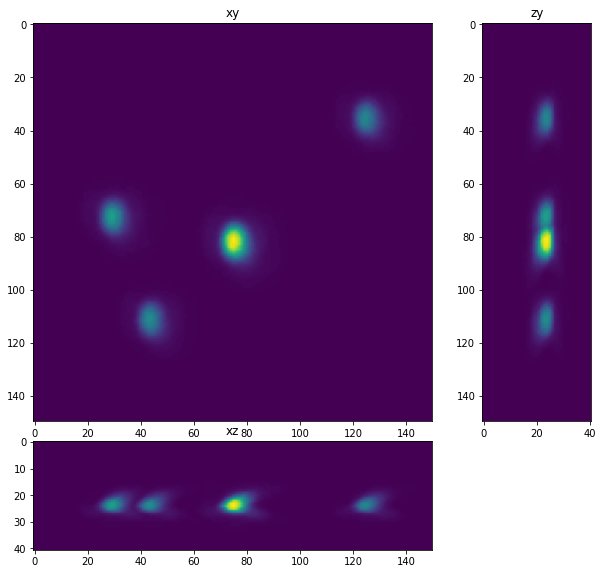

In [49]:
fig=show_xyz_max(im,1,axial_stretch)

## Threshold the beads

In this case a simple global Otsu does an alright job at thresholding the beads.  This step may need to be tweaked for images with different characteristics.

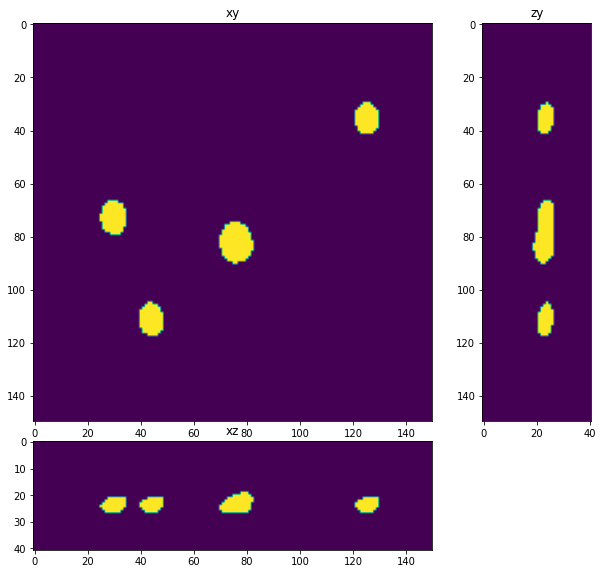

In [50]:
thresholded = im>threshold_otsu(im)
fig=show_xyz_max(thresholded,1,axial_stretch)

## Find bead centroids

In this step we create a label image, create region properties for each label so we can get the centroid of each bead.  We create an empty image and draw a point at each centroid.  This aproximates the 'true object' of the field of sub-resolution beads

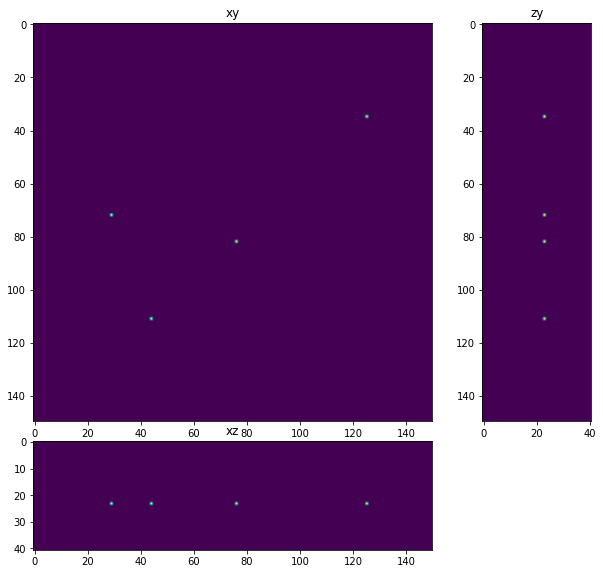

In [51]:
labels=label(thresholded)

from skimage.measure import regionprops
import numpy as np
centroids = np.zeros_like(labels)

objects = regionprops(labels)

for o in objects:
    centroids[int(o.centroid[0]),int(o.centroid[1]),int(o.centroid[2])]=1
fig=show_xyz_max(centroids,1,axial_stretch)

# Note drawing centroids is wrapped in the below convenience method
# from tnia.segmentation.rendering import draw_centroids
# centroids = draw_centroids(thresholded)

## Aproximate PSF using 'reverse Deconvolution' a.k.a. PSF Distilling

In this step we perform a reverse deconvolution to solve for the PSF.  The acquired image is the convolution of a PSF and a 'true object'.  The 'true object' is the deconvolution of the image using the PSF.  However if we know the true object (in this case a field of sub-resolution beads) we can reverse the role of object and PSF, and solve for the PSF
```
Image=convolution(object,psf)

object=deconvolution(image,psf)

psf=deconvolution(image,object)
```

We use clij to perform the Richardson Lucy deconvolution however any implementation of Richardson Lucy deconvolution could be used at this step

get lib


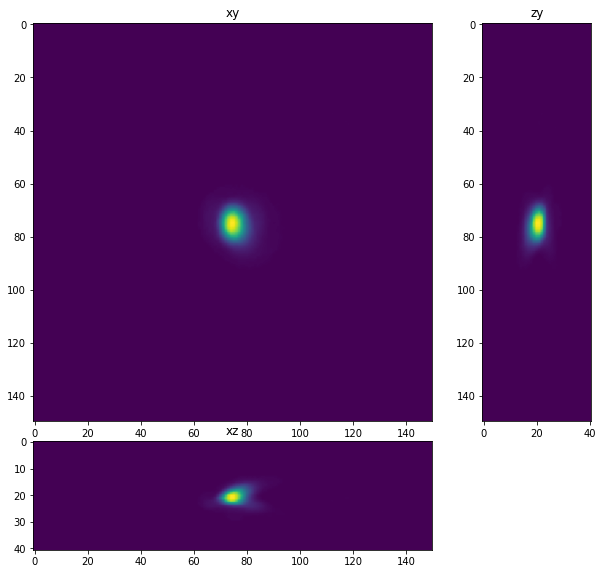

In [52]:
from clij2fft.richardson_lucy import richardson_lucy
im_32=im.astype('float32')
centroids_32=centroids.astype('float32')
first_guess=np.ones_like(im_32)
psf=richardson_lucy(im_32, centroids_32, 200)#, first_guess=first_guess)
psf_cropped=psf
fig = show_xyz_max(psf,1,axial_stretch)

## View in 3D

If we have napari installed we can view our PSF in 3D

In [101]:
# start napari
import napari
viewer = napari.Viewer()

# show images
viewer.add_image(psf, scale = [3,1,1])
#viewer.add_image(im, scale = [3,1,1])
#viewer.add_image(thresholded, scale = [3,1,1])

<Image layer 'psf' at 0x1dedfb4aac0>

Exception in callback BaseAsyncIOLoop._handle_events(9400, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(9400, 1)>
Traceback (most recent call last):
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 448, in _handle_events
    self._handle_recv()
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 477, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-pac

get lib


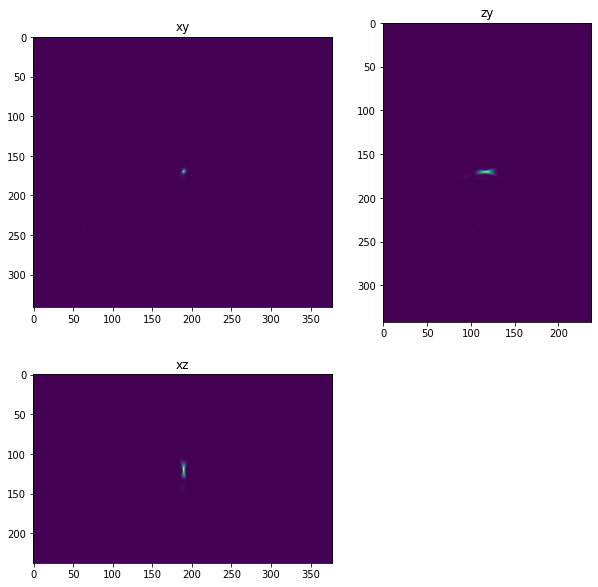

In [126]:
# note that the above steps can be accessed from a convenience function as follows
from tnia.deconvolution.psfs import psf_from_beads
psf=psf_from_beads(im)
fig = show_xyz_max(psf)